# Testing

In [1]:
import os
    #choose gpu on processing 
os.environ["CUDA_VISIBLE_DEVICES"]="" # second gpu  

In [2]:
import pandas as pd
df0 = pd.read_csv (r'/home/yupaporn/codes/USAI/detail1_350_.csv')
df01 = df0[(df0['Path Crop']!='None' )&(df0['Path Crop']!='Nan')]
#select data 
# df02 = df01.loc[(df01['Abs Position']  == 'P1' ) | (df01['Abs Position']  == 'P2')]
# df02 = df01.loc[(df01['Abs Position']  == 'P3' ) | (df01['Abs Position']  == 'P4')]
df02 = df01.loc[(df01['Abs Position']  == 'P5' ) | (df01['Abs Position']  == 'P6')]
# df02 = df01.loc[df01['Abs Position']  == 'P7']

### Load model

In [3]:
width = 150 
height = 150 
input_shape = (height, width, 3)

In [4]:
import sys
sys.path.append('/media/tohn/SSD/FP_C_Nor_Abnor_B3NA_24/content/efficientnet_keras_transfer_learning')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

Using TensorFlow backend.


In [5]:
#load model 
from tensorflow.keras.models import load_model
model = load_model("/media/tohn/SSD/FP_C_Nor_Abnor_B3NA_24/content/efficientnet_keras_transfer_learning/models/FP_C_small.h5")

### Prediction

In [6]:
a = df02[df02['Case'].between(1, 10)]
print(a.shape)
print('Normal: ',a[a['Class']=='Normal'].shape)
print('Abnormal: ',a[a['Class']=='Abnormal'].shape)

(113, 8)
Normal:  (34, 8)
Abnormal:  (79, 8)


In [7]:
from tensorflow.keras.preprocessing import image
import pandas as pd

In [8]:
def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])[0][0]
    if result > 0.5:
        classs = "Normal"
    else:
        classs = "Abnormal"
        result = 1 - result
    return classs,result

In [9]:
classe =['Normal','Abnormal']
results = list()
# predlist,problist = list(), list()

for i in classe:
    img_path =a[a['Class']==i]['Path Crop'].tolist()
    for j in img_path:
        classs,result = predict_image(j)
        results.append({'2Actual':i,'3Predicted':classs, '4Class_prob':result,'path':j})

In [10]:
result = pd.DataFrame(results)
result

,2Actual,3Predicted,4Class_prob,path
0,Normal,Normal,1.000000,/media/tohn/HDD/VISION_dataset/USAI/Prelim. Im...
1,Normal,Normal,0.999988,/media/tohn/HDD/VISION_dataset/USAI/Prelim. Im...
2,Normal,Normal,0.999999,/media/tohn/HDD/VISION_dataset/USAI/Prelim. Im...
3,Normal,Normal,0.999986,/media/tohn/HDD/VISION_dataset/USAI/Prelim. Im...
4,Normal,Normal,1.000000,/media/tohn/HDD/VISION_dataset/USAI/Prelim. Im...
5,Normal,Normal,0.999950,/media/tohn/HDD/VISION_dataset/USAI/Prelim. Im...
6,Normal,Normal,0.999998,/media/tohn/HDD/VISION_dataset/USAI/Prelim. Im...
7,Normal,Normal,1.000000,/media/tohn/HDD/VISION_dataset/USAI/Prelim. Im...
8,Normal,Normal,0.999985,/media/tohn/HDD/VISION_dataset/USAI/Prelim. Im...
9,Normal,Normal,0.999039,/media/tohn/HDD/VISION_dataset/USAI/Prelim. Im...


In [11]:
os.chdir( '/home/yupaporn/codes/USAI/')
result.to_csv('resultNA24_C_b3NA.csv')

# Visualization

In [12]:
data_train = result
#เช็คคลาสใน Predicted
pred_class = set(data_train['3Predicted'])
print('Predicted : ',len(pred_class))
print(pred_class)
#เช็คคลาสใน Actual
classe = set(data_train['2Actual'])
print('Actual : ',len(classe))
print(classe)

Predicted :  2
{'Normal', 'Abnormal'}
Actual :  2
{'Normal', 'Abnormal'}


### Confusion matrix & Scores

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix
act = data_train['2Actual'].array
pred = data_train['3Predicted'].array

classes =['Normal','Abnormal']

In [14]:
cmat = confusion_matrix(act, pred, classes)
# print('fan classifier accuracy = {}%'.format((100.*numpy.trace(cmat))/(numpy.sum(cmat))))
print('fan classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

fan classifier accuracy = 89.38053097345133%


/home/yupaporn/miniconda3/envs/eff/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['Normal', 'Abnormal'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [15]:
#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
# confusion_matrix(act, pred)
print(classification_report(act, pred))#performance

              precision    recall  f1-score   support

    Abnormal       1.00      0.85      0.92        79
      Normal       0.74      1.00      0.85        34

    accuracy                           0.89       113
   macro avg       0.87      0.92      0.88       113
weighted avg       0.92      0.89      0.90       113



In [16]:
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])
conf_mat

Predicted,Abnormal,Normal
Actual,,
Abnormal,67,12
Normal,0,34


Text(48.5, 0.5, 'Predicted label')

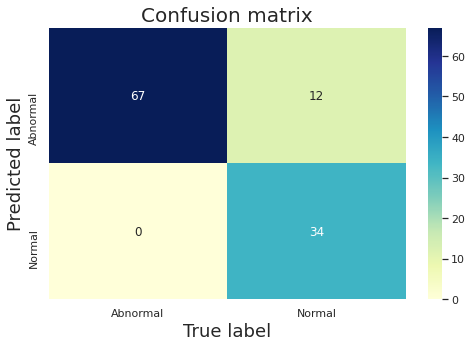

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_xlabel('True label',fontsize=18)
ax.set_ylabel('Predicted label',fontsize=18)

### ROC & AUC

In [20]:
import numpy as np
# classes =['P1','P2','P3','P4','P5','P6','P7','P8']
# classes =['P2']
classes =['Abnormal', 'Normal']
threshold = np.arange(0.0, 1.002, 0.001)

TN, FP, FN, TP = list(),list(),list(),list()
precision, recall, ACC, TPR, FPR, SPEC = list(),list(),list(),list(),list(),list()

for i in threshold:
    TN0, FP0, FN0, TP0 = list(),list(),list(),list()
    precision0, recall0, ACC0, TPR0, FPR0, SPEC0 = list(),list(),list(),list(),list(),list()
    
    for j in classes:
        tn,fp,fn,tp = confusion_matrix_all(data_train,j,i) 
        try:
            pre = tp/(tp+fp)
            re= tp/(tp+fn)
            acc = (tp+tn)/(tp+tn+fp+fn)
            tpr = tp/(tp+fn)
            fpr = fp/(fp+tn)
            spec = 1-(tn/(tn+fp))
        except ZeroDivisionError:
            pre,re,acc,tpr,fpr,spec =1,0,0,0,0,0      
            
        TP0.append(tp)
        TN0.append(tn)
        FP0.append(fp)
        FN0.append(fn)
        precision0.append(pre)
        recall0.append(re)
        ACC0.append(acc)
        TPR0.append(re)
        FPR0.append(fpr)       
        SPEC0.append(spec)
        
    precision.append(precision0)
    recall.append(recall0)
    ACC.append(ACC0)
    TPR.append(TPR0)
    FPR.append(FPR0)       
    SPEC.append(SPEC0)

( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0

/home/yupaporn/.local/lib/python3.6/site-packages/ipykernel_launcher.py:62: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 

( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0

( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12

( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12

( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0

( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12 , 67 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 12

( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 13 , 66 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 13 , 66 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 13 , 66 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 13 , 66 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 13 , 66 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 13 , 66 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 13 , 66 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 13 , 66 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 13 , 66 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 67 , 12 , 0

( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 69 , 10 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 13 , 66 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 69 , 10 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 13 , 66 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 69 , 10 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 13 , 66 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 69 , 10 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 13 , 66 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 69 , 10 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 13 , 66 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 69 , 10 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 13 , 66 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 69 , 10 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 13 , 66 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 69 , 10 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 13 , 66 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 69 , 10 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 13

( 34 , 0 , 17 , 62 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 71 , 8 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 17 , 62 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 71 , 8 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 17 , 62 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 71 , 8 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 17 , 62 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 71 , 8 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 17 , 62 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 71 , 8 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 18 , 61 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 71 , 8 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 18 , 61 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 71 , 8 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 18 , 61 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 71 , 8 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 18 , 61 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 71 , 8 , 0 , 34 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
(

( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 72 , 7 , 1 , 33 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 21 , 58 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 72 , 7 , 1 , 33 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 21 , 58 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 72 , 7 , 1 , 33 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 21 , 58 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 72 , 7 , 1 , 33 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 21 , 58 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 72 , 7 , 1 , 33 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 21 , 58 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 72 , 7 , 1 , 33 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 21 , 58 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 72 , 7 , 1 , 33 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 21 , 58 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 72 , 7 , 1 , 33 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 21 , 58 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 72 , 7 , 1 , 33 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 21 , 58 )
(

( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 30 , 49 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 73 , 6 , 2 , 32 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 30 , 49 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 73 , 6 , 2 , 32 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 31 , 48 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 73 , 6 , 2 , 32 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 31 , 48 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 73 , 6 , 2 , 32 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 31 , 48 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 73 , 6 , 2 , 32 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 31 , 48 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 73 , 6 , 2 , 32 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 31 , 48 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 73 , 6 , 2 , 32 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 31 , 48 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 73 , 6 , 2 , 32 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 32 , 47 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 73 , 6 , 2 , 32 )
(

( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 76 , 3 , 2 , 32 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 43 , 36 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 76 , 3 , 2 , 32 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 44 , 35 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 76 , 3 , 2 , 32 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 44 , 35 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 76 , 3 , 2 , 32 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 44 , 35 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 76 , 3 , 2 , 32 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 44 , 35 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 76 , 3 , 2 , 32 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 44 , 35 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 76 , 3 , 2 , 32 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 44 , 35 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 76 , 3 , 2 , 32 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 45 , 34 )
( 67 , 12 , 0 , 34 )
(TN,FP,FN,TP)
( 76 , 3 , 2 , 32 )
( 34 , 0 , 12 , 67 )
(TN,FP,FN,TP)
( 34 , 0 , 45 , 34 )
(

In [21]:
#average per threshold 
precision1,recall1,ACC1,TPR1,FPR1,SPEC1 = list(),list(),list(),list(),list(),list()
from statistics import *
for m in range(0,len(precision)):
    a1 =mean(precision[m])
    a2 =mean(recall[m])
    a3 =mean(ACC[m])
    a4 =mean(TPR[m])
    a5 =mean(FPR[m])
    a6 =mean(SPEC[m])
    
    precision1.append(a1)
    recall1.append(a2)
    ACC1.append(a3)
    TPR1.append(a4)
    FPR1.append(a5)       
    SPEC1.append(a6)   

In [22]:
#create dataframe
import numpy as np
i = np.arange(len(precision1)) # index for df
roc0 = pd.DataFrame({'Threshold' : pd.Series(threshold, index=i),'Precision' : pd.Series(precision1, index = i),'Recall' : pd.Series(recall1, index = i),'tpr' : pd.Series(TPR1, index = i),'fpr' : pd.Series(FPR1, index = i),'1-Spec' : pd.Series(SPEC1, index = i),  'ACC' : pd.Series(ACC1, index = i)})
roc0 = roc0.fillna(1)

fix_value = [{'Threshold':0.000,'Precision':0.000,'Recall':1.000,'tpr':1.000,'fpr':1.000,'1-Spec':1.000,'ACC':0.000}]
roc0 = roc0.append(fix_value,ignore_index=True,sort=False)
roc0 = roc0.apply(np.roll, shift=1) #move he last row to the first

No handles with labels found to put in legend.


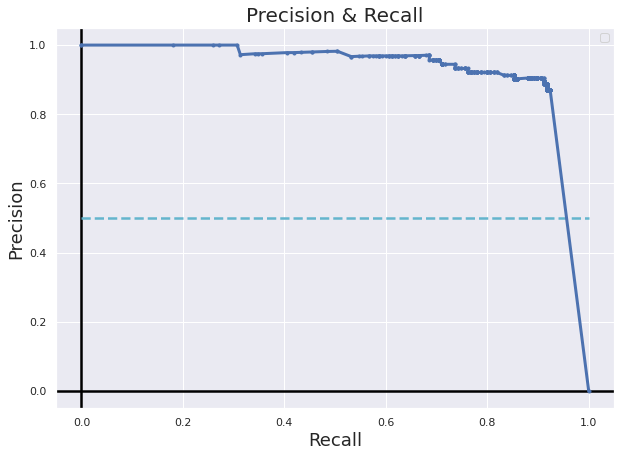

PR AUC (area = 0.93)


In [23]:
import numpy as np
    #Precision & Recall Curve
recall = np.array(roc0['Recall'])
precision = np.array(roc0['Precision'])

import matplotlib.pyplot as plt
from matplotlib import pyplot
lw = 3
fig, ax = plt.subplots(figsize=(10, 7))
plt.axhline(0, lw=2.5, color='black')
plt.axvline(0, lw=2.5, color='black')
# ax.set_facecolor(('w'))
fig.patch.set_facecolor('w')
plt.plot([0, 1], [0.5, 0.5],'c', linestyle='--',lw=2.5)
pyplot.plot(recall, precision, marker='.', lw=lw)
    # axis labels
pyplot.xlabel('Recall',fontsize=18)
pyplot.ylabel('Precision',fontsize=18)
pyplot.title('Precision & Recall',fontsize=20)
    # show the legend
pyplot.legend()
    # show the plot
pyplot.show()


    # calculate the precision-recall auc
from sklearn.metrics import auc
auc_score = auc(recall, precision)
print('PR AUC (area = %0.2f)' % (auc_score))

No handles with labels found to put in legend.


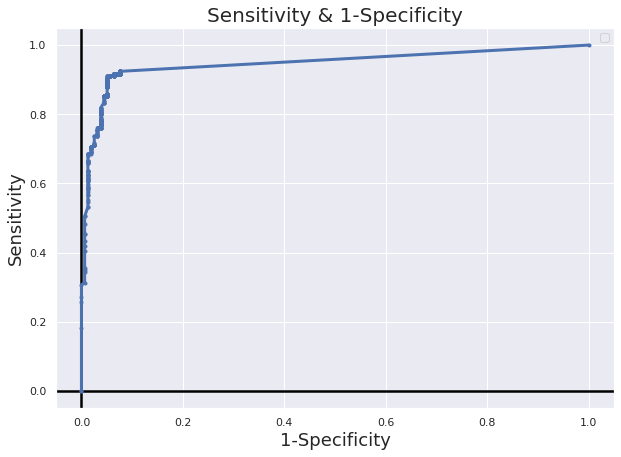

PR AUC (area = 0.95)


In [24]:
    #sen VS spec
import numpy as np
sen= np.array(roc0['tpr'])
spec = np.array(roc0['1-Spec'])

from matplotlib import pyplot
lw = 3
fig, ax = plt.subplots(figsize=(10, 7))
plt.axhline(0, lw=2.5, color='black')
plt.axvline(0, lw=2.5, color='black')
fig.patch.set_facecolor('w')
plt.plot([0, 0],[1, 1],'c', linestyle='--',lw=2.5)
pyplot.plot(spec,sen, marker='.',lw=lw)  

    # axis labels
pyplot.xlabel('1-Specificity',fontsize=18)
pyplot.ylabel('Sensitivity',fontsize=18)
pyplot.title('Sensitivity & 1-Specificity',fontsize=20)

    # show the legend
pyplot.legend()
    # show the plot
pyplot.show()


    # calculate the precision-recall auc
from sklearn.metrics import auc
auc_score = auc(spec, sen)
print('PR AUC (area = %0.2f)' % (auc_score))

In [18]:
def confusion_matrix_all(data_train,classes,threshold):


    #1. manage data  --------------------------------------------------------------------------------------------------------------------------------------------------

    p1 = data_train #Input table
   
    if classes =='Normal':
        act= p1['2Actual'].map({'Normal':1,'Abnormal':0}).values
        pred = p1['3Predicted'].map({'Normal':1,'Abnormal':0}).values
    else:
        act= p1['2Actual'].map({'Normal':0,'Abnormal':1}).values
        pred = p1['3Predicted'].map({'Normal':0,'Abnormal':1}).values

    prob_all = p1['4Class_prob'].to_numpy()

    #2. เงื่อนไข ---------------------------------------------------------------------------------------------------------------------------------------------

    TP,TN,FP,FN,posi_tp,posi_tn,posi_fp,posi_fn = list(), list(), list(), list(),list(), list(), list(), list()
    for i in range(len(act)):
        if act[i] & pred[i]  == 1:
            tp = 1
            po_tp = i
            TP.append(tp)
            posi_tp.append(po_tp)
        elif act[i] == 0: 
            if pred[i]  == 1:
                fp = 1
                po_fp = i
                FP.append(fp)
                posi_fp.append(po_fp)  

        if act[i] == 1: 
            if pred[i]  == 0:
                fn = 1
                po_fn = i
                FN.append(fn)
                posi_fn.append(po_fn) 
        elif act[i] | pred[i]  == 0:
            tn = 1
            po_tn = i
            TN.append(tn)
            posi_tn.append(po_tn)



    print('(',len(TN),',', len(FP),',', len(FN),',', len(TP) ,')')

# 3. threshold ----------------------------------------------------------------

    if  posi_tp or posi_fp  != 0:      
                #Keep only interested TP, FP 
        inter_point = posi_tp+posi_fp
        inter = act[inter_point]
        prob = prob_all[inter_point]

        import numpy as np
        from sklearn.metrics import confusion_matrix

#         threshold = 0
        t = prob >= threshold
        t = np.where(t=='True', 1, t) #repalce True-1,False-0

        tp_new,tn_new,fp_new,fn_new = list(),list(),list(),list()
        for i in range(len(inter)):
            if inter[i] & t[i]  == 1:
                tp0 = 1
                tp_new.append(tp0)

            elif inter[i] == 0: 
                if t[i]  == 1:
                    fp0 = 1
                    fp_new.append(fp0) 

            if inter[i] == 1: 
                if t[i]  == 0:
                    fn0 = 1
                    fn_new.append(fn0)

            elif inter[i] | t[i]  == 0:
                tn0 = 1
                tn_new.append(tn0)  #find  confusion matrix

        if TN.count(1) !=0:
            tn_new = TN.count(1)+tn_new.count(1)
        else : 
            tn_new = tn_new.count(1)    
        if FN.count(1) !=0:
            fn_new = FN.count(1)+fn_new.count(1)
        else :
            fn_new = fn_new.count(1)

        fp_new = fp_new.count(1)
        tp_new = tp_new.count(1)

        print('(TN,FP,FN,TP)')
        print('(',tn_new,',', fp_new,',', fn_new,',', tp_new ,')')

        return tn_new, fp_new, fn_new, tp_new

    else :
        print('(TN,FP,FN,TP)')
        print('(',TN.count(1),',', FP.count(1),',', FN.count(1),',', TP.count(1) ,')')

        return TN.count(1),  FP.count(1), FN.count(1), TP.count(1) 

In [19]:

#Plot ROC
def plot_roc(roc0):
    
    import numpy as np
    #Precision & Recall Curve
    recall = np.array(roc0['Recall'])
    precision = np.array(roc0['Precision'])


    import matplotlib.pyplot as plt
    from matplotlib import pyplot
    lw = 2
    plt.plot([0, 1], [0.5, 0.5], linestyle='--', lw=lw)
    pyplot.plot(recall, precision, marker='.', label='Multiclass')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.title('Precision & Recall')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()


    # calculate the precision-recall auc
    from sklearn.metrics import auc
    auc_score = auc(recall, precision)
    print('PR AUC (area = %0.2f)' % (auc_score))

    #_______________________________________________________________________________________________

    #FPR VS TPR

    import numpy as np
    tpr= np.array(roc0['tpr'])
    fpr = np.array(roc0['fpr'])

    from matplotlib import pyplot

    pyplot.plot(fpr, tpr, marker='.', label='Multiclass')  #กลับด้านทำไม?????
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('true Positive Rate')
    pyplot.title('False Positive Rate & true Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()


    # calculate the precision-recall auc
    from sklearn.metrics import auc
    auc_score = auc(fpr, tpr)
    print('PR ROC (area = %0.2f)' % (auc_score))

    #_______________________________________________________________________________________________

    #sen VS spec

    import numpy as np
    sen= np.array(roc0['tpr'])
    spec = np.array(roc0['1-Spec'])

    from matplotlib import pyplot
    pyplot.plot(spec,sen, marker='.', label='Multiclass')  

    # axis labels
    pyplot.xlabel('1-Specificity')
    pyplot.ylabel('Sensitivity')
    pyplot.title('Sensitivity & 1-Specificity')

    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()


    # calculate the precision-recall auc
    from sklearn.metrics import auc
    auc_score = auc(spec, sen)
    print('PR AUC (area = %0.2f)' % (auc_score))